In this notebook, we will finally create predictive features using the logs we cleaned on notebook 2.2. Our focus, for now, will be prediction using an aggregate non-temporal representation of each student.

Throughout the notebook, we will start with the import of logs and remaining tables that we consider to be relevant for feature engineering and extraction.

#### 1. Importing the relevant packages, setting global variables and importing the relevant files

In [1]:
#import libs
import pandas as pd
import numpy as np

#viz related tools
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns

#tqdm to monitor progress
from tqdm.notebook import tqdm, trange
tqdm.pandas(desc="Progress")

#time related features
from datetime import timedelta

#starting with other tools
sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#global variables that may come in handy
#course threshold sets the % duration that will be considered (1 = 100%)
duration_threshold = [0.1, 0.25, 0.33, 0.5, 1]

#colors for vizualizations
nova_ims_colors = ['#BFD72F', '#5C666C']

#standard color for student aggregates
student_color = '#474838'

#standard color for course aggragates
course_color = '#1B3D2F'

#standard continuous colormap
standard_cmap = 'viridis_r'

In [3]:
#loading student log data 
student_logs = pd.read_csv('../Data/Modeling Stage/R_Gonz_cleaned_logs.csv', 
                           dtype = {
                                   'id': object,
                                   'itemid': object,
                                   'userid': object,
                                   'course': object,
                                   'cmid': object,
                                   },
                                   parse_dates = ['time'],).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1) #logs

#loading support table
support_table = pd.read_csv('../Data/R_Gonz_support_table.csv', 
                           dtype = {
                                   'assign_id': object,
                                   'courseid': object,
                                   'userid': object,
                                   }, 
                            parse_dates = ['sup_time', 'startdate']).drop('Unnamed: 0', axis = 1).dropna(how = 'all', axis = 1)

#save tables 
class_list = pd.read_csv('../Data/Modeling Stage/R_Gonz_class_duration.csv', 
                         dtype = {
                                   'course': object,                                   
                                   },
                        parse_dates = ['Start Date','End Date', 'cuttoff_point']).drop('Unnamed: 0', axis = 1).rename(columns = {'cuttoff_point' : 'Week before start'})

#targets tables 
targets_table = pd.read_csv('../Data/Modeling Stage/R_Gonz_targets_table.csv',
                           dtype = {
                                   'userid': object,
                                   'courseid': object,
                                   },)

We'll start with the general verification of the different datasets we've imported. 

**Starting with the targets table, which includes all valid student-course logs with Final-Grade.**

In [4]:
#get info
targets_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30510 entries, 0 to 30509
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   courseid         30510 non-null  object 
 1   userid           30510 non-null  object 
 2   Grade Mandatory  26676 non-null  float64
 3   Grade Optional   16485 non-null  float64
 4   final_mark       30510 non-null  float64
dtypes: float64(3), object(2)
memory usage: 1.2+ MB


In [5]:
targets_table.describe(include = 'all', datetime_is_numeric = True)

,courseid,userid,Grade Mandatory,Grade Optional,final_mark
count,30510,30510,26676.000000,16485.000000,30510.000000
unique,732,14111,NaN,NaN,NaN
top,2271.0,36779.0,NaN,NaN,NaN
freq,667,10,NaN,NaN,NaN
mean,NaN,NaN,0.303199,0.086236,4.715297
std,NaN,NaN,0.151369,0.144909,3.121882
min,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,0.210688,0.000000,2.194832
50%,NaN,NaN,0.339517,0.000000,4.666666
75%,NaN,NaN,0.424005,0.125375,7.423107


In [6]:
targets_table

,courseid,userid,Grade Mandatory,Grade Optional,final_mark
0,1000.0,17391.0,0.500000,NaN,10.000000
1,1000.0,21448.0,0.469512,0.0,4.695122
2,1000.0,21844.0,0.469512,NaN,9.390244
3,1000.0,22429.0,0.451220,NaN,9.024390
4,1000.0,22535.0,0.256098,NaN,5.121951
...,...,...,...,...,...
30505,999.0,74108.0,0.316667,0.0,3.166667
30506,999.0,74173.0,0.311667,0.0,3.116667
30507,999.0,74256.0,0.328333,0.0,3.283333
30508,999.0,8491.0,0.380000,0.0,3.800000


Then, we repeat the same for the list of courses and their respective start and end dates. We know that the number of students attending each course is the number found in the logs. We will need to make further cuts 

In [7]:
class_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   course                562 non-null    object        
 1   Users per course      562 non-null    float64       
 2   Start Date            562 non-null    datetime64[ns]
 3   End Date              562 non-null    datetime64[ns]
 4   Course duration days  562 non-null    float64       
 5   Week before start     562 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(2), object(1)
memory usage: 26.5+ KB


In [8]:
class_list.describe(include = 'all', datetime_is_numeric = True)

,course,Users per course,Start Date,End Date,Course duration days,Week before start
count,562,562.000000,562,562,562.000000,562
unique,562,NaN,NaN,NaN,NaN,NaN
top,1000.0,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,51.046263,2014-11-16 17:51:01.921708288,2015-03-17 21:26:15.800711680,122.149466,2014-11-09 17:51:01.921708288
min,NaN,1.000000,2014-08-24 00:00:00,2014-10-01 00:00:00,29.000000,2014-08-17 00:00:00
25%,NaN,17.000000,2014-09-09 00:00:00,2015-01-15 00:00:00,98.000000,2014-09-02 00:00:00
50%,NaN,34.000000,2014-10-20 00:00:00,2015-02-25 00:00:00,122.000000,2014-10-13 00:00:00
75%,NaN,69.000000,2015-01-24 18:00:00,2015-05-25 00:00:00,137.000000,2015-01-17 18:00:00
max,NaN,642.000000,2015-06-01 00:00:00,2015-07-10 00:00:00,306.000000,2015-05-25 00:00:00


In [9]:
class_list

,course,Users per course,Start Date,End Date,Course duration days,Week before start
0,1000.0,12.0,2014-08-31,2015-01-19,142.0,2014-08-24
1,1002.0,22.0,2014-09-28,2015-03-04,158.0,2014-09-21
2,1010.0,48.0,2014-09-11,2014-12-22,103.0,2014-09-04
3,1013.0,71.0,2014-09-23,2015-02-02,133.0,2014-09-16
4,1020.0,64.0,2015-01-11,2015-06-04,145.0,2015-01-04
...,...,...,...,...,...,...
557,984.0,13.0,2014-08-31,2015-01-27,150.0,2014-08-24
558,985.0,22.0,2014-08-24,2015-02-25,186.0,2014-08-17
559,992.0,16.0,2015-02-09,2015-05-12,93.0,2015-02-02
560,993.0,55.0,2014-09-11,2015-01-12,124.0,2014-09-04


We still note a significant presence of courses with small numbers of students. The first step we will take is the removal of all courses whose number of attending students is below 10.

In [10]:
class_list = class_list[class_list['Users per course'] >= 10]

#updating student logs
student_logs = student_logs[student_logs['course'].isin(class_list['course'])]

#additionally updating targets_table
targets_table = targets_table[targets_table['courseid'].isin(class_list['course'])]
class_list.describe(include = 'all', datetime_is_numeric = True)

,course,Users per course,Start Date,End Date,Course duration days,Week before start
count,497,497.000000,497,497,497.000000,497
unique,497,NaN,NaN,NaN,NaN,NaN
top,1000.0,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,57.052314,2014-11-15 07:05:54.929577472,2015-03-17 12:56:29.939637760,123.243461,2014-11-08 07:05:54.929577472
min,NaN,10.000000,2014-08-24 00:00:00,2014-10-01 00:00:00,29.000000,2014-08-17 00:00:00
25%,NaN,22.000000,2014-09-08 00:00:00,2015-01-14 00:00:00,101.000000,2014-09-01 00:00:00
50%,NaN,43.000000,2014-10-15 00:00:00,2015-02-11 00:00:00,123.000000,2014-10-08 00:00:00
75%,NaN,73.000000,2015-01-24 00:00:00,2015-05-25 00:00:00,137.000000,2015-01-17 00:00:00
max,NaN,642.000000,2015-05-31 00:00:00,2015-07-10 00:00:00,306.000000,2015-05-24 00:00:00


We'll follow up with taking a closer look logs we cleaned in the previous section. 

In [11]:
student_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6792901 entries, 0 to 6869430
Data columns (total 10 columns):
 #   Column  Dtype         
---  ------  -----         
 0   id      object        
 1   time    datetime64[ns]
 2   userid  object        
 3   ip      object        
 4   course  object        
 5   module  object        
 6   cmid    object        
 7   action  object        
 8   url     object        
 9   info    object        
dtypes: datetime64[ns](1), object(9)
memory usage: 570.1+ MB


In [12]:
student_logs.describe(include = 'all', datetime_is_numeric = True)

,id,time,userid,ip,course,module,cmid,action,url,info
count,6792901,6792901,6792901,6792901,6792901,6792901,6792901,6792901,6787605,6548661
unique,6792901,NaN,13042,73768,497,31,26932,103,187728,48194
top,262124.0,NaN,47527.0,127.0.0.1,2059.0,course,0.0,view,view.php?id=2271,Ver página de estado de las entregas propios.
freq,1,NaN,40537,4035544,129398,2781729,3120077,5382515,57347,640410
mean,NaN,2015-01-16 09:53:32.107981568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2014-08-25 12:03:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2014-11-09 21:11:53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2015-01-10 18:44:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2015-03-23 14:25:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2015-07-09 10:57:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
student_logs

,id,time,userid,ip,course,module,cmid,action,url,info
0,262124.0,2014-08-25 12:03:21,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
1,262137.0,2014-08-25 12:04:40,68582.0,127.0.0.1,985.0,folder,35183.0,view,view.php?id=35183,680
2,262161.0,2014-08-25 12:07:37,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
3,262162.0,2014-08-25 12:07:43,68582.0,127.0.0.1,985.0,folder,35189.0,view,view.php?id=35189,685
4,268473.0,2014-08-26 10:23:43,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
...,...,...,...,...,...,...,...,...,...,...
6869426,46109453.0,2015-06-22 08:39:09,77225.0,127.0.0.1,5688.0,forum,0.0,view forums,index.php?id=5688,NaN
6869427,46287163.0,2015-06-24 08:35:37,77225.0,127.0.0.1,5688.0,course,0.0,view,view.php?id=5688,5688
6869428,45940294.0,2015-06-18 08:57:58,52262.0,127.0.0.1,2411.0,course,0.0,view,view.php?id=2411,2411
6869429,45940340.0,2015-06-18 08:58:35,52262.0,127.0.0.1,2411.0,resource,105562.0,view,view.php?id=105562,68316


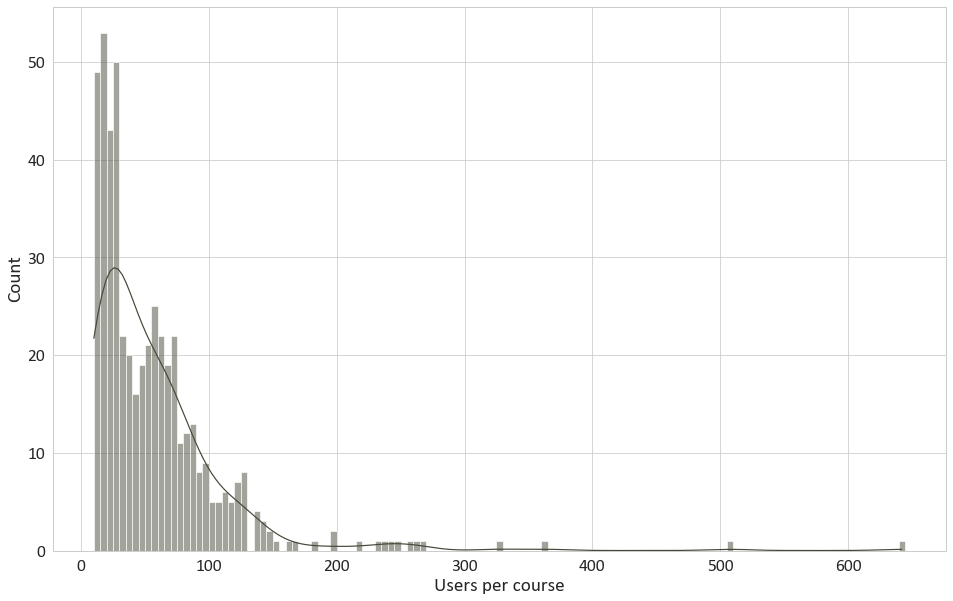

In [14]:
#then we plot an histogram with all courses, we are not interested in keeping courses with a number of students inferior to 10
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(16, 10)}, font_scale=2)
hist4 = sns.histplot(data=class_list, x='Users per course', kde=True, color= student_color, binwidth = 5,)

fig = hist4.get_figure()
fig.savefig('../Images/hist4_students_per_course_bin_5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, hist4


Likewise, there is some attention to be found on courses with abnormally high numbers of attending students in a face-to-face context (over 200). We will pay closer attention to those courses.

In [15]:
#create df only with high affluence courses
most_affluent_courses = class_list[class_list['Users per course'] >= 200]

#separate logs accordingly
high_attendance_logs = student_logs[student_logs['course'].isin(most_affluent_courses['course'])]
high_attendance_logs

,id,time,userid,ip,course,module,cmid,action,url,info
37257,385876.0,2014-09-03 10:32:56,69599.0,127.0.0.1,2007.0,course,0.0,view,view.php?id=2007,2007
37258,385897.0,2014-09-03 10:33:10,69599.0,127.0.0.1,2007.0,user,0.0,view all,index.php?id=2007,NaN
37259,386427.0,2014-09-03 10:39:27,69599.0,127.0.0.1,2007.0,course,0.0,view,view.php?id=2007,2007
37260,386624.0,2014-09-03 10:42:23,69599.0,127.0.0.1,2007.0,course,0.0,view,view.php?id=2007,2007
37261,386635.0,2014-09-03 10:42:28,69599.0,127.0.0.1,2007.0,resource,83279.0,view,view.php?id=83279,53711
...,...,...,...,...,...,...,...,...,...,...
6851482,46228634.0,2015-06-23 13:44:08,47237.0,127.0.0.1,3022.0,course,0.0,view,view.php?id=3022,3022
6851483,46530043.0,2015-06-28 13:59:04,47237.0,127.0.0.1,3022.0,course,0.0,view,view.php?id=3022,3022
6869428,45940294.0,2015-06-18 08:57:58,52262.0,127.0.0.1,2411.0,course,0.0,view,view.php?id=2411,2411
6869429,45940340.0,2015-06-18 08:58:35,52262.0,127.0.0.1,2411.0,resource,105562.0,view,view.php?id=105562,68316


In [16]:
high_attendance_logs.describe(include = 'all', datetime_is_numeric = 'all')

,id,time,userid,ip,course,module,cmid,action,url,info
count,812003,812003,812003,812003,812003,812003,812003,812003,810396,798046
unique,812003,NaN,2680,8729,12,15,1001,34,26329,2009
top,385876.0,NaN,63280.0,127.0.0.1,2059.0,course,0.0,view,view.php?id=2271,2271
freq,1,NaN,2982,608123,129398,356245,374609,673457,57347,57462
mean,NaN,2015-02-16 20:29:18.531203072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2014-09-03 10:32:56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2014-12-11 22:41:04.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2015-03-04 17:32:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2015-04-20 09:49:38.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,2015-06-28 23:23:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can plot the weekly interactions of these courses.

In [17]:
#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs.groupby([pd.Grouper(key='time', freq='W'), 'course']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['course'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index('Course', drop = True)
grouped_data.T.describe(include = 'all').T

,count,mean,std,min,25%,50%,75%,max
Course,,,,,,,,
2007,18.0,2106.055556,1100.755007,116.0,1594.25,1977.5,2705.25,4439.0
2024,21.0,3182.571429,1973.936361,233.0,1540.00,2949.0,4940.00,6549.0
2059,19.0,6810.421053,4453.744097,1277.0,3700.50,5636.0,10547.50,16615.0
2271,18.0,5975.111111,3868.764994,445.0,3792.50,4467.5,9135.25,14147.0
2288,19.0,4139.421053,2721.201334,1533.0,2243.50,3173.0,4674.00,10809.0
2411,23.0,2794.434783,1978.090122,123.0,1494.00,2555.0,3421.50,7784.0
2607,22.0,4725.772727,4132.541383,550.0,2611.50,3851.0,5337.25,20018.0
3022,30.0,1465.800000,1372.654700,94.0,247.25,1331.0,1893.00,5552.0
3033,19.0,2110.631579,1560.074400,524.0,820.00,1478.0,2935.50,5435.0


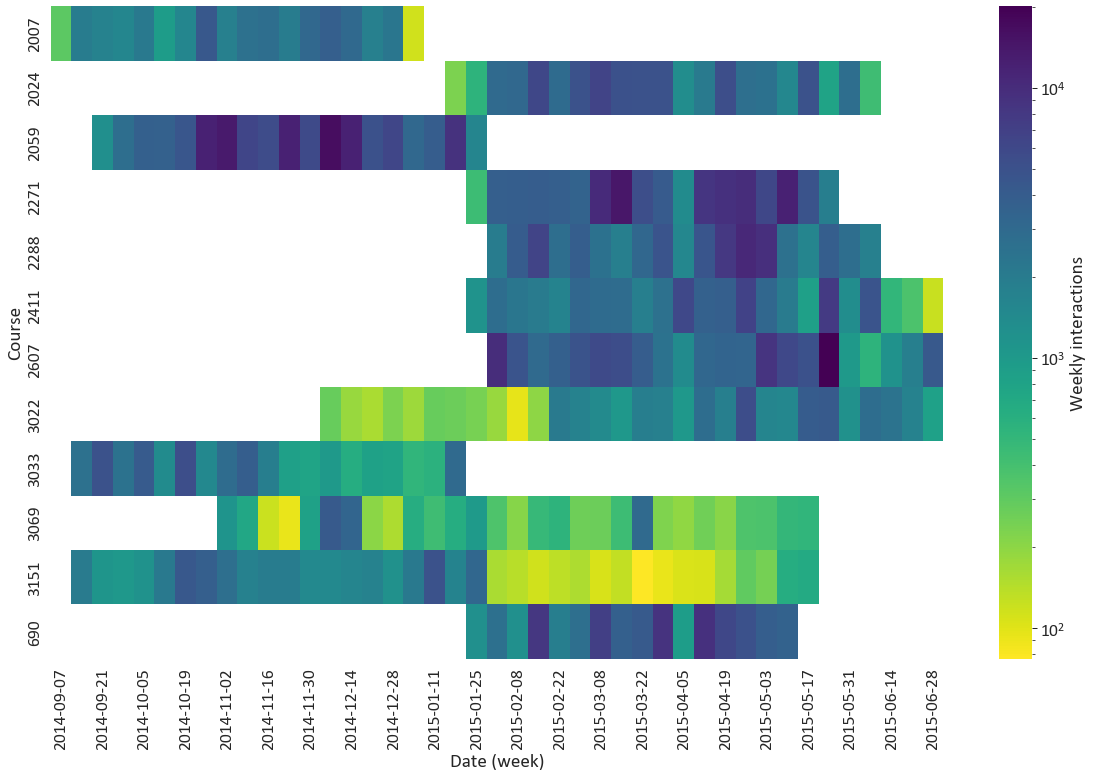

In [18]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat4 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 1,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat4.get_figure()
fig.savefig('../Images/highest_attendance_weekly_clicks_heat4.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat4

While most courses are very clearly restricted to their semester, there are courses that have interactions occurring across the entire year. 

For these courses, we just want to undestand whether all students are interacting continuously or we are speaking of different co-horts of students. As such, we will look more deeply at the following courses:

3022, 3069 and 3151

In [19]:
year_long_high_attendance = ['3022.0', '3069.0', '3151.0']

#Then, when it comes to logs, we aggregate by week
grouped_data = high_attendance_logs[high_attendance_logs['course'].isin(year_long_high_attendance)].groupby([pd.Grouper(key='time', freq='W'), 'course', 'userid']).agg({
                                                                             'action': 'count',
                                                                             }).reset_index().sort_values('time')
#change for better reading
grouped_data['Date (week)'] = grouped_data['time'].astype(str)

#creating pivot table to create heatmap
grouped_data = grouped_data.pivot_table(index =['course', 'userid'], 
                       columns = 'Date (week)',
                        values = 'action', 
                       aggfunc =np.sum,
                        fill_value=np.nan).reset_index().rename(columns = {'course' : 'Course'})

#now, we will sort the courses according to the starting date
grouped_data['Course'] = pd.to_numeric(grouped_data['Course']).astype(int)

#finally we create the pivot_table that we will use to create our heatmap
grouped_data = grouped_data.set_index(['Course', 'userid'], drop = True)
grouped_data.T.describe(include = 'all').T

count       mean        std  min   25%   50%    75%    max
Course userid                                                             
3022   14727.0   23.0  20.173913  30.986290  1.0  2.50  11.0  19.50  142.0
       19329.0   15.0  21.733333  24.618421  1.0  4.00   8.0  42.00   67.0
       23000.0   19.0  12.526316  10.073995  1.0  3.50  10.0  21.50   33.0
       23427.0   13.0  17.230769  19.110005  2.0  5.00  12.0  17.00   67.0
       26356.0   16.0  14.937500  14.359521  1.0  3.00  11.0  19.75   54.0
...               ...        ...        ...  ...   ...   ...    ...    ...
3151   66551.0   22.0  17.454545  18.712683  1.0  5.00  11.0  26.00   77.0
       71150.0   25.0  27.160000  28.125730  1.0  3.00  21.0  33.00  104.0
       72025.0    8.0   8.625000   4.565007  2.0  5.75   9.0   9.75   17.0
       72952.0    8.0   7.750000   4.621379  1.0  4.75   7.5  10.00   15.0
       74192.0   13.0  17.769231  16.161445  1.0  5.00  13.0  25.00   52.0

[719 rows x 8 columns]

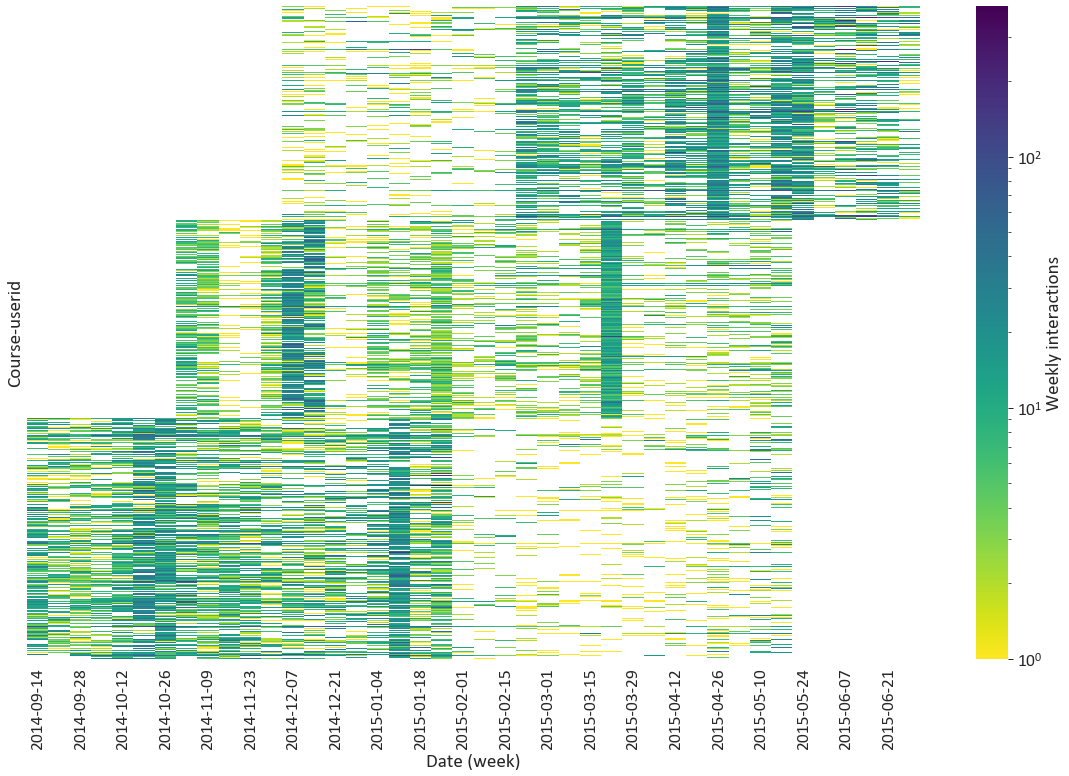

In [20]:
sns.set_theme(context='paper', style='whitegrid', font='Calibri', rc={"figure.figsize":(20, 12)}, font_scale=2)

#here, we are plotting the nex
heat5 = sns.heatmap(grouped_data, robust=True, norm=LogNorm(), xticklabels = 2, yticklabels= 0,
            cmap = standard_cmap, cbar_kws={'label': 'Weekly interactions'})

fig = heat5.get_figure()
fig.savefig('../Images/high_attend_yearlong_weekly_heat5.png', transparent=True, dpi=300)

#delete to remove from memory
del fig, heat5, grouped_data, high_attendance_logs

After consideration, we find that the student interactions seem to be consistent with the course duration. 

We note, however, that the accesses to course 4923 seem to be inconsistent at best. We will monitor this course (and others) in the following steps. For now, we will proceed with the analysis over targets and support table.

**1. First, we filter by our current list of valid courses.**

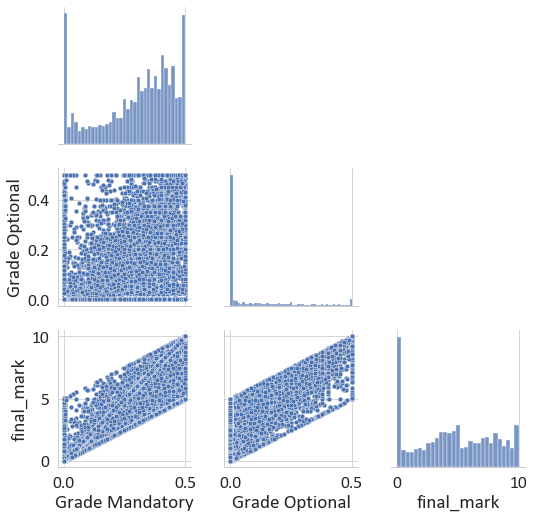

In [21]:
#Representation of different targets depending 
g = sns.PairGrid(targets_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

In [22]:
#a larger overlook at the different courses
targets_table.groupby('courseid').agg({
                                    'userid' : 'count', 
                                    'Grade Mandatory' : ['min', 'mean', 'max'],
                                    'Grade Optional' : ['min', 'mean', 'max'],                                    
                                    'final_mark' : ['min', 'mean', 'max'],
                                    }).describe(include = 'all')

userid Grade Mandatory                         Grade Optional  \
            count             min        mean         max            min   
count  497.000000      458.000000  458.000000  458.000000     341.000000   
mean    58.191147        0.125894    0.321753    0.444563       0.022735   
std     58.908021        0.143509    0.111034    0.100442       0.072687   
min     10.000000        0.000000    0.001389    0.002000       0.000000   
25%     22.000000        0.000000    0.257481    0.439024       0.000000   
50%     43.000000        0.074629    0.337678    0.480010       0.000000   
75%     73.000000        0.250000    0.398472    0.500000       0.000000   
max    667.000000        0.500000    0.500000    0.500000       0.500000   

                               final_mark                          
             mean         max         min        mean         max  
count  341.000000  341.000000  497.000000  497.000000  497.000000  
mean     0.100072    0.226144    1.657305    5.006286    7.812234  
std      0.134345    0.210166    2.307943    2.524070    2.563269  
min      0.000000    0.000000    0.000000    0.002941    0.037500  
25%      0.000000    0.000000    0.000000    3.118316    6.133333  
50%      0.029778    0.186973    0.014144    4.922883    9.000000  
75%      0.168874    0.466666    3.000000    7.102041   10.000000  
max      0.500000    0.500000   10.000000   10.000000   10.000000

#### Finally, we will take a look at the support table we have and repeat the same steps performed thus far

In [23]:
#separate logs accordingly
support_table = support_table[support_table['courseid'].isin(class_list['course'])]

#get info
support_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214821 entries, 0 to 220940
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   assign_id         214821 non-null  object        
 1   courseid          214821 non-null  object        
 2   startdate         214821 non-null  datetime64[ns]
 3   userid            214821 non-null  object        
 4   sup_time          214821 non-null  datetime64[ns]
 5   mandatory_status  214821 non-null  float64       
 6   delivered         214821 non-null  int64         
 7   assignment_mark   214821 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 14.8+ MB


In [24]:
support_table.describe(include = 'all', datetime_is_numeric = True)

,assign_id,courseid,startdate,userid,sup_time,mandatory_status,delivered,assignment_mark
count,214821,214821,214821,214821,214821,214821.000000,214821.000000,214821.000000
unique,5376,497,NaN,13293,NaN,NaN,NaN,NaN
top,98648.0,2271.0,NaN,68626.0,NaN,NaN,NaN,NaN
freq,657,17871,NaN,131,NaN,NaN,NaN,NaN
mean,NaN,NaN,2014-11-23 08:18:08.725962240,NaN,2015-02-09 04:03:59.822526464,0.559438,0.607915,0.411553
min,NaN,NaN,2014-08-24 22:00:00,NaN,2014-09-04 16:41:44,0.000000,0.000000,0.000000
25%,NaN,NaN,2014-09-09 22:00:00,NaN,2014-12-05 09:19:14,0.000000,0.000000,0.000000
50%,NaN,NaN,2014-11-25 23:00:00,NaN,2015-02-13 10:48:19,1.000000,1.000000,0.337500
75%,NaN,NaN,2015-01-26 23:00:00,NaN,2015-04-19 21:29:37,1.000000,1.000000,0.833333
max,NaN,NaN,2015-05-31 22:00:00,NaN,2015-07-23 08:09:32,1.000000,1.000000,1.000000


In [25]:
support_table

,assign_id,courseid,startdate,userid,sup_time,mandatory_status,delivered,assignment_mark
0,588.0,18.0,2014-09-03 22:00:00,17881.0,2014-11-04 16:22:27,1.0,1,1.0
1,588.0,18.0,2014-09-03 22:00:00,18204.0,2014-11-04 16:22:36,1.0,1,1.0
2,588.0,18.0,2014-09-03 22:00:00,18541.0,2014-11-04 16:22:45,1.0,1,1.0
3,588.0,18.0,2014-09-03 22:00:00,22888.0,2014-11-04 16:22:51,1.0,1,1.0
4,588.0,18.0,2014-09-03 22:00:00,23037.0,2014-11-04 16:22:58,1.0,1,1.0
...,...,...,...,...,...,...,...,...
220936,272959.0,4635.0,2015-05-28 22:00:00,38229.0,2015-06-03 17:26:07,1.0,1,0.7
220937,272959.0,4635.0,2015-05-28 22:00:00,72728.0,2015-06-03 10:51:30,1.0,1,0.8
220938,272959.0,4635.0,2015-05-28 22:00:00,73387.0,2015-06-03 17:26:49,1.0,1,0.7
220939,272959.0,4635.0,2015-05-28 22:00:00,73390.0,2015-07-02 09:20:43,1.0,0,0.0


In [26]:
#a larger overlook at the different courses
support_table.groupby('courseid').agg({
                                    'userid' : 'count',
                                    'assign_id' : 'count', 
                                    'mandatory_status' : 'mean',
                                    'delivered' : 'mean',                                    
                                    'assignment_mark' : 'mean',
                                    }).describe(include = 'all')

,userid,assign_id,mandatory_status,delivered,assignment_mark
count,497.000000,497.000000,497.000000,497.000000,497.000000
mean,432.235412,432.235412,0.697331,0.747753,0.518928
std,993.171900,993.171900,0.338091,0.298144,0.267556
min,12.000000,12.000000,0.000000,0.001969,0.000394
25%,72.000000,72.000000,0.470588,0.536585,0.318880
50%,174.000000,174.000000,0.841121,0.894019,0.561250
75%,459.000000,459.000000,1.000000,1.000000,0.729311
max,17871.000000,17871.000000,1.000000,1.000000,1.000000


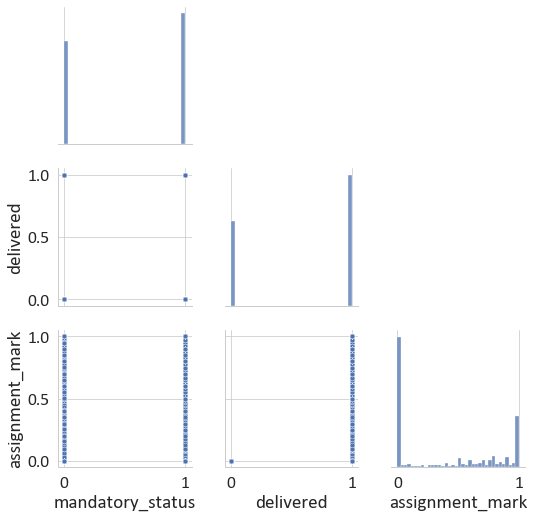

In [27]:
#Representation of different targets depending 
g = sns.PairGrid(support_table, diag_sharey=False, corner=True)
g.map_diag(sns.histplot)
g.map_lower(sns.scatterplot)
g.add_legend()

**Going forward**.

After this preliminary look, we will go forward with extracting features from the Moodle logs. 

In this notebook, we will consider a static non-temporal representation that considers each student-course pair as a row. We will, however, construct different datasets - 1 for each relevant timestep. 

We will rely on features that are regular presences in the literature. Some of these features may appear in more than one work:

**From Macfadyen et al. (2010)**

Count related features:
- Discussion messages posted, 
- Online Sessions, 
- File views,
- Assessments finished, 
- Assessments started, 
- Replies to discussion messages, 
- Mail messages sent, 
- Assignments submitted, 
- Discussion MEssages read, 
- Web link views

Time related features:
- Total time online, 
- Time spent on assignments,


**From Romero et al. (2013)**

Number Accesses to:
- Assignments done,
- Quizzes passed,
- Quizzes failed,
- Forum messages posted, 
- Forum messages read,

Time related features:
- Total time on assignments, 
- Total time on quizzes, 
- Total time on forums

**From Gasevic et. al (2016)**

Number of Accesses of the following variables:
- course logins,
- forum,
- resources,
- Turnitin file submission,
- assignments,
- book,
- quizzes, 
- feedback,
- lessons,
- virtual classroom
- chat,

- etc...

**From Conijn et. al (2017)**

Click count related features:
- Clicks,
- Online sessions, 
- Course page views,
- Resources viewed,
- Links viewed, 
- Discussion post views,
- Content page views,
- Quizzes,
- Quizzes passed,
- Assignments submitted, 
- Wiki edits,
- Wiki views,

Time related features:
- Total time online,
- Largest period of inactivity,
- Time until first action, 
- Averages session time,

Performance related features:
- Average assignment grade,

**Chen and Cui (2020)**

Click count related features:
- Total clicks, 
- Clicks on campus, 
- Online sessions,
- Clicks during weekdays,
- Clicks on weekend,
- Assignments, 
- File,
- Forum,
- Overview Report,
- Quizz,
- System, 
- User Report

Time related features
- Total time of online sessions, 
- Mean duration of online sessions, 
- SD of time between sessions, 
- Total time on Quiz, 
- Total time on File, 
- SD of time on File, 

Other statistics
- Ratio between on-campups and off-campus clicks

As stated, some of the features are calculated across multiple works - and these only address the course level. They are not designed specifically for course-agnostic purposes.

**We will split the logs by the difference courses and, for each student calculate the different features we intend to calculate. We will start with the the features that have appeared repeatedly and transition into other, less frequent features.**

First, we'll start with estimating the intended duration and calculate the log threshold dates - dependant on the % we want to consider

In [28]:
#additionally, we will look at our estimated course duration
for i in tqdm(duration_threshold):
    #create, for each desired threshold, the appropriate cutoff date 
    class_list[f'Date_threshold_{int(i*100)}%'] = pd.to_datetime((class_list['Start Date'] + pd.to_timedelta(class_list['Course duration days'] * i, unit = 'Days')).dt.date)
    
#then, we will create a dictionary of dictionaries, each main dictionary storing and a version of the logs

logs_dict = {}

for i in tqdm(duration_threshold):
    #create, for each desired threshold, a different dictionary of dataframes wherein we will perform the different operations 
    logs_dict[f'Date_threshold_{int(i*100)}%'] = {course: student_logs.loc[student_logs['course'] == course].reset_index(drop = True) for course in tqdm(student_logs['course'].unique())}

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

In [29]:
#taking a look at an example dataframe
logs_dict['Date_threshold_10%']['985.0']

,id,time,userid,ip,course,module,cmid,action,url,info
0,262124.0,2014-08-25 12:03:21,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
1,262137.0,2014-08-25 12:04:40,68582.0,127.0.0.1,985.0,folder,35183.0,view,view.php?id=35183,680
2,262161.0,2014-08-25 12:07:37,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
3,262162.0,2014-08-25 12:07:43,68582.0,127.0.0.1,985.0,folder,35189.0,view,view.php?id=35189,685
4,268473.0,2014-08-26 10:23:43,68582.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
...,...,...,...,...,...,...,...,...,...,...
4503,28217890.0,2015-02-11 15:28:46,75944.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
4504,28217957.0,2015-02-11 15:29:02,75944.0,127.0.0.1,985.0,assign,35161.0,view,view.php?id=35161,View own submission status page.
4505,28791524.0,2015-02-16 02:21:31,75944.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985
4506,29343484.0,2015-02-18 23:11:43,75944.0,127.0.0.1,985.0,course,0.0,view,view.php?id=985,985


Now, we have a nested dictionary with different dataframes inside it. We will use this data structure to perform the most of the operations we are interested in.

**First, we will add, to each dataframe, a column with the corresponding threshold date.**

A double loop will be inefficient but, to the best of my ability, still is the best way to perform these operations.

In [48]:
#in each dictionary
for i in tqdm(logs_dict):
    #for each dataframe
    for j in tqdm(logs_dict[i]):
        #where the course is the same as in the class_list, get the corresponding value of the appropriate column,
        logs_dict[i][j]['Date Threshold'] = class_list['course'].map(class_list)[i][j]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

KeyError: '985.0'

In [46]:
for i in tqdm(logs_dict):
    #for each dataframe
    for j in tqdm(logs_dict[i]):
        #where the course is the same as in the class_list, get the corresponding value of the appropriate column,
         logs_dict[i][j]['Date Threshold']

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

In [47]:
logs_dict['Date_threshold_10%']['985.0']['Date Threshold']

0       a
1       a
2       a
3       a
4       a
       ..
4503    a
4504    a
4505    a
4506    a
4507    a
Name: Date Threshold, Length: 4508, dtype: object